In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import h5py
plt.rcParams["figure.figsize"] = (11,7)

In [92]:
infile = open ("higgs_100000_pt_250_500.pkl", 'rb')
data_signal = pickle.load(infile)

signal = pd.DataFrame(data_signal)
signal.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [3]:
infile2 = open ("qcd_100000_pt_250_500.pkl", 'rb')
data_bg = pickle.load(infile2)

background = pd.DataFrame(data_bg)
background.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [4]:
hf = h5py.File('data_highLumi_pt_250_500.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

In [5]:
hf = h5py.File('data_lowLumi_pt_250_500.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

### 1. Make a stacked histogram plot for the feature variable: mass

In [6]:
def plot_stack_norm(key):
    plt.hist([signal[key], background[key]], bins = 300, weights = [[(100/21000)/100000]*len(signal),[(20000/20000)/100000]*len(background)], stacked = True, histtype = 'step', label = ['Higgs', 'QCD'], color = ['orange','blue']) 
    plt.xlabel(key)
    plt.ylabel("probability")
    plt.legend()
    plt.title('Plot of ' + key)
    plt.show()
       

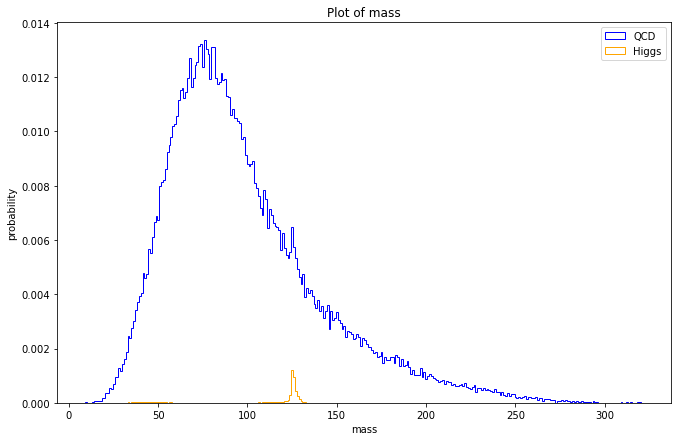

In [7]:
plot_stack_norm('mass')

Here I have stacked the histograms of the mass for the signal and background. I have normalized the two distributions by their expected yield per 100,000 data points. 

#### Evaluate expected significance without any event selection. Use Poisson statistics for significance calculation. Compare the exact significance to the approximation $\frac{N_{Higgs}}{\sqrt(N_{QCD})} $. If they are equivalent, explain your findings.

From the classification of the low pt data, we have a poisson background with a mean of 20000 and an expected 100 Higgs events. We can calculate the significance of the background plus the amount of expected events. 

Here we are trying to answer the statistical question: what is the significance for the background to produce a signal of 21000 or higher? 

In [8]:
# Calculate significance
p = (1-scipy.stats.poisson.cdf(20100, 20000))
print('sigma significance of {0:1.2f}'.format(stats.norm.ppf(1-p)))

sigma significance of 0.71


In [9]:
# Approximation 
print('{0:1.2f}'.format(100/np.sqrt(20000)))

0.71


We get the same significance from the two calculations because we are looking at the sigma value for 100 away from a mean of $\lambda$ = 20000, and for a Poisson distribution the standard deviation is calculated by $\sqrt(\lambda)$. So $\frac{N_{Higgs}}{\sqrt(N_{QCD})} $ will approximate the sigma significance of 100 away from the mean. The first method uses the fact that at a high lambda value, a Poisson distribution will approximate a Gaussian, according to the central limit theorem. The second method is simply how to calculate the significance for a Poisson distribution. 

### 2. Identify mass cuts to optimize the expected significance.
Try different mass cuts systematically

Evaluate expected significance for each set of mass cuts

Identify the set of mass cuts which give you the highest significance.

In [90]:
def slicer(lower, upper, key, sig, bkgd, state):
    bkgd_low = bkgd[bkgd[key] < lower].index
    bkgd_high = bkgd[bkgd[key] > upper].index
    new_bg = bkgd.drop(bkgd_low)
    new_bg = new_bg.drop(bkgd_high)
    
    signal_low = sig[sig[key] < lower].index
    signal_high = sig[sig[key] > upper].index
    new_signal = sig.drop(signal_low)
    new_signal = new_signal.drop(signal_high)

    a = 0.2
    b = 0.001
    y_bg = int(a * len(new_bg))
    percent_bg = len(new_bg) / 100000
    y_signal = int(b * len(new_signal))
    percent_signal = len(new_signal) / 100000
    
    lam = y_bg 
    signal = y_bg + y_signal
    p = stats.poisson.sf(signal, lam)
    sigma = stats.norm.ppf(1-p)
    if state == True:
        print('Significance of {0:1.3f} for a cut from {1:1.1f} to {2:1.1f}'.format(sigma,lower,upper))
    
    return(new_signal, new_bg, sigma)

In [93]:
signal_slice, bkgd_slice, sigma = slicer(0,300, 'mass', signal, background, True)
signal_slice, bkgd_slice, sigma = slicer(100, 150, 'mass', signal, background, True)
signal_slice, bkgd_slice, sigma = slicer(110, 130, 'mass', signal, background, True)
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background, True)

Significance of 0.711 for a cut from 0.0 to 300.0
Significance of 1.173 for a cut from 100.0 to 150.0
Significance of 1.695 for a cut from 110.0 to 130.0
Significance of 2.387 for a cut from 120.0 to 130.0


After making slices for several ranges of the mass, the best significance appears to be when we cut between 120 and 130. 

### 3. Make two sets of stacked histogram plots for the rest of the features
Set A without any event selection

In [12]:
def plot_stack_slice(key):
    plt.hist([signal_slice[key], bkgd_slice[key]], 300, weights = [[.001]*len(signal_slice),[.2]*len(bkgd_slice)], stacked = True, histtype = 'step',color = ['orange','blue']) 
    plt.xlabel(key)
    plt.ylabel('Probability')
    plt.title('Plot of ' + key + ' with mass cut')
    plt.show()

In [13]:
def plot_mult(key):
        plot_stack_norm(key)
        plot_stack_slice(key)

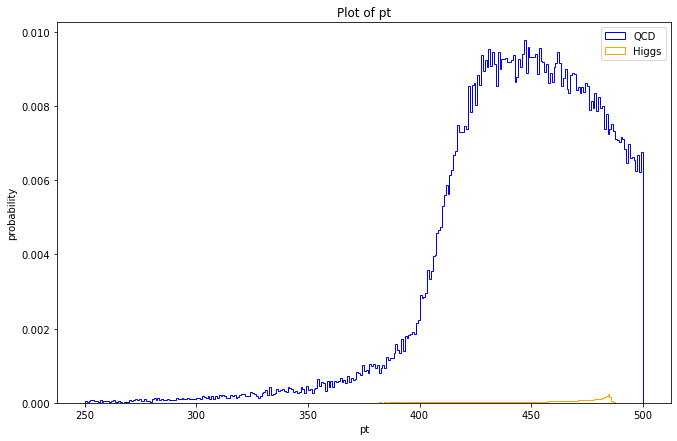

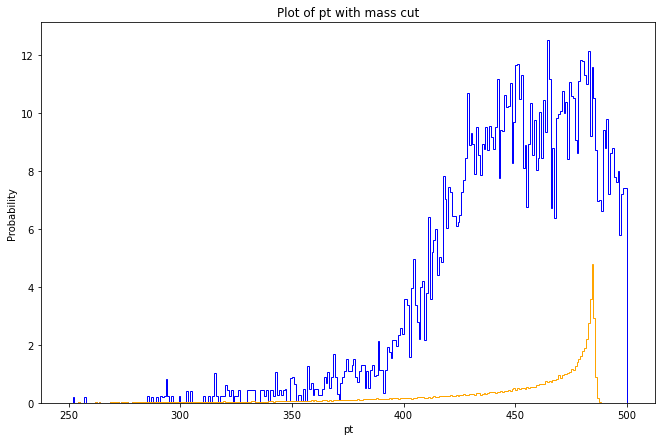

In [14]:
plot_mult('pt')

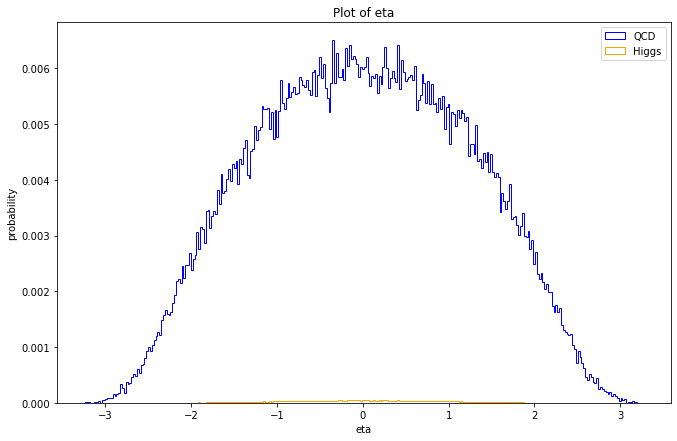

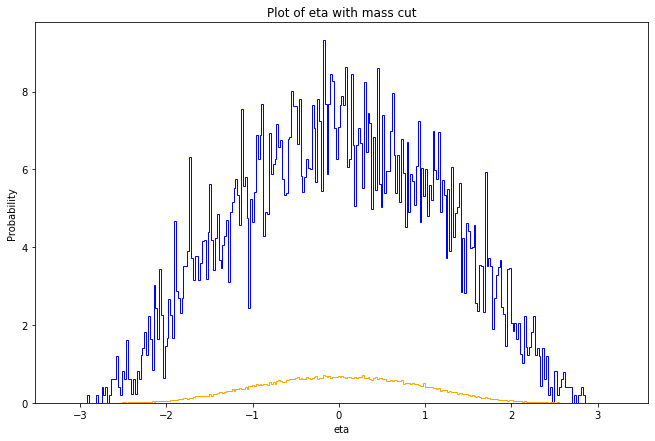

In [15]:
plot_mult('eta')

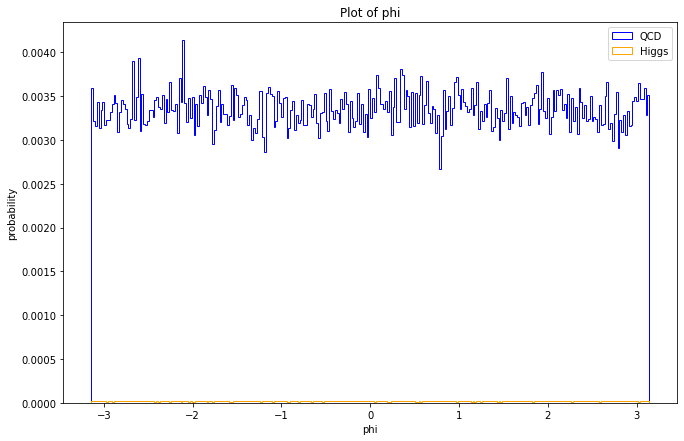

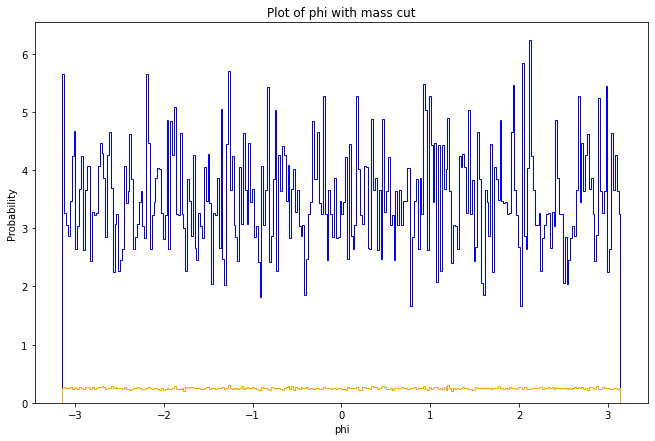

In [16]:
plot_mult('phi')

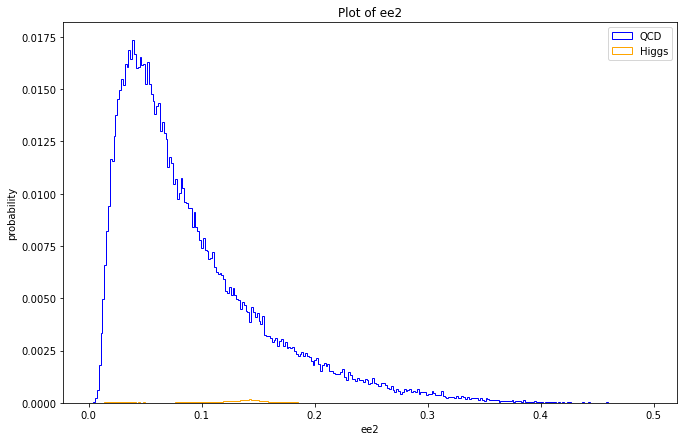

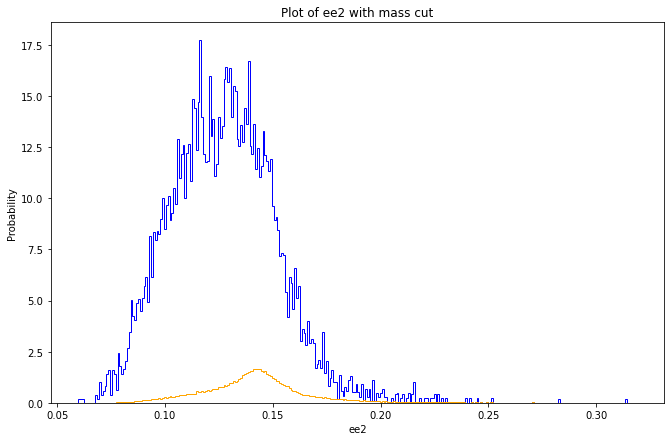

In [17]:
plot_mult('ee2')

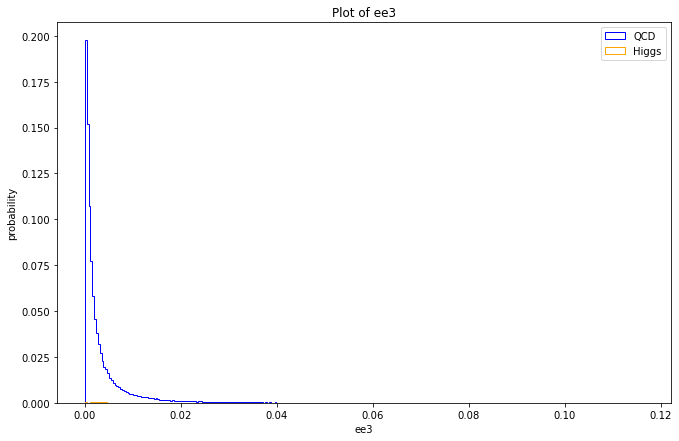

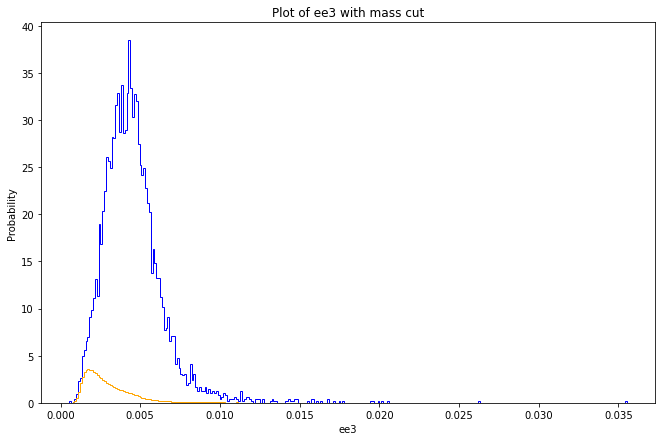

In [18]:
plot_mult('ee3')

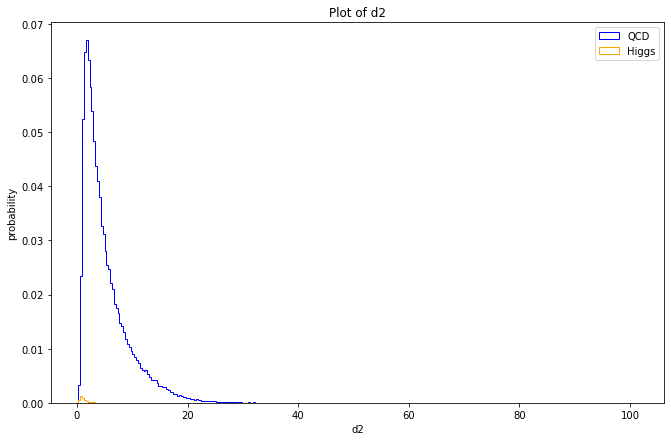

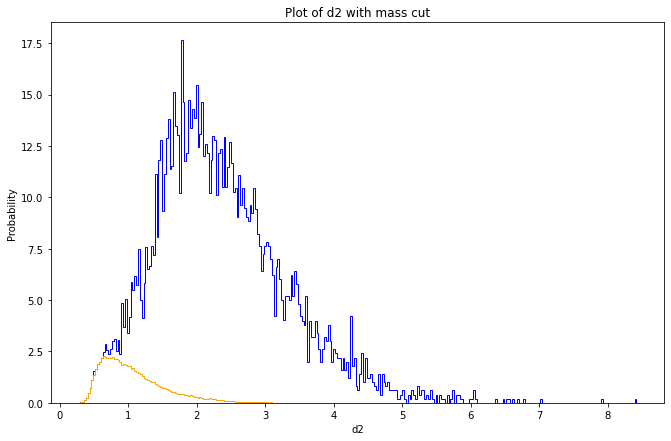

In [19]:
plot_mult('d2')

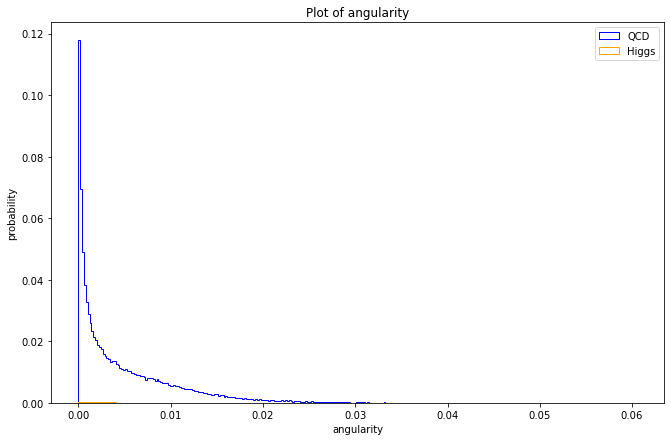

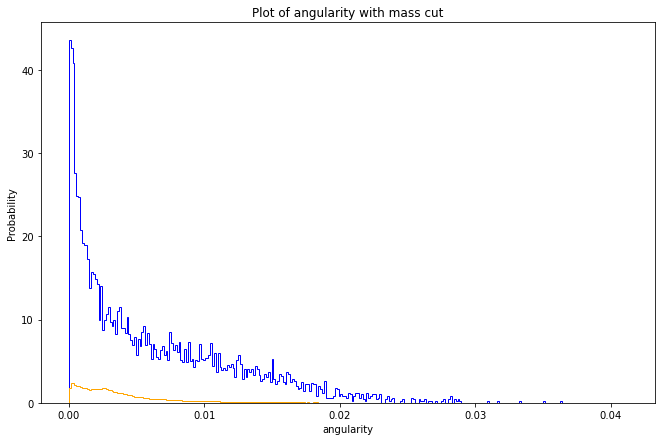

In [20]:
plot_mult('angularity')

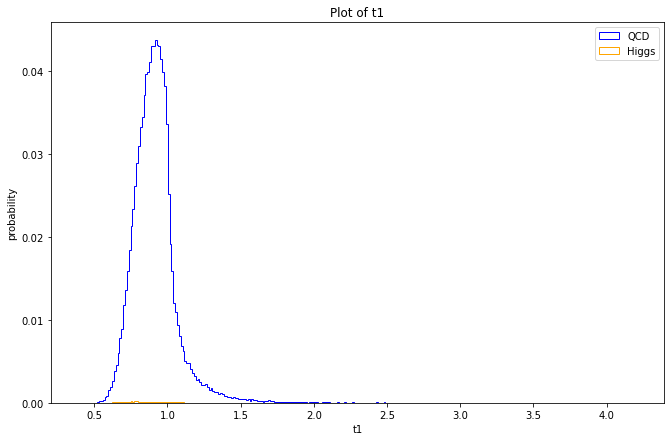

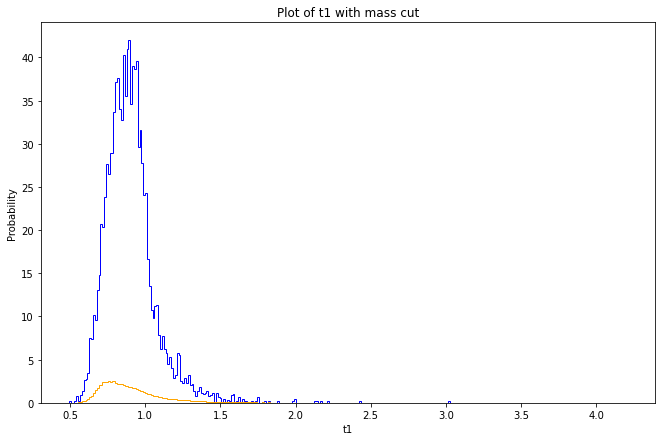

In [21]:
plot_mult('t1')

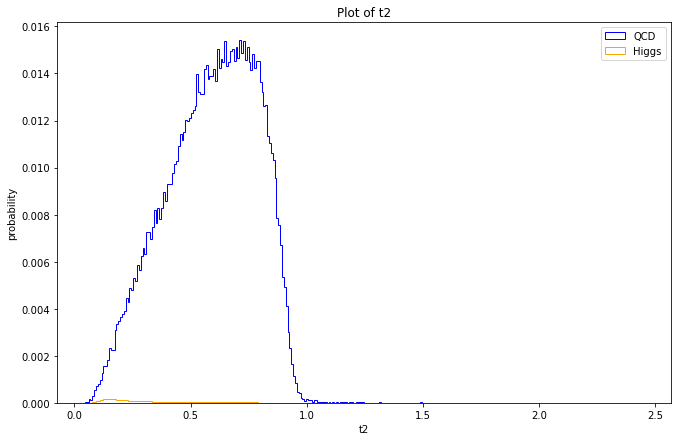

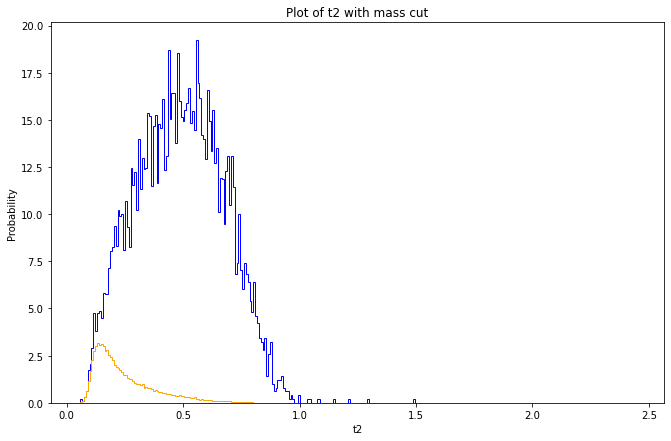

In [22]:
plot_mult('t2')

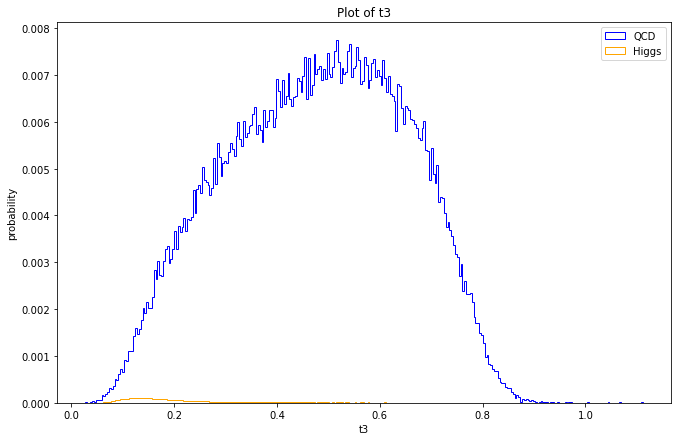

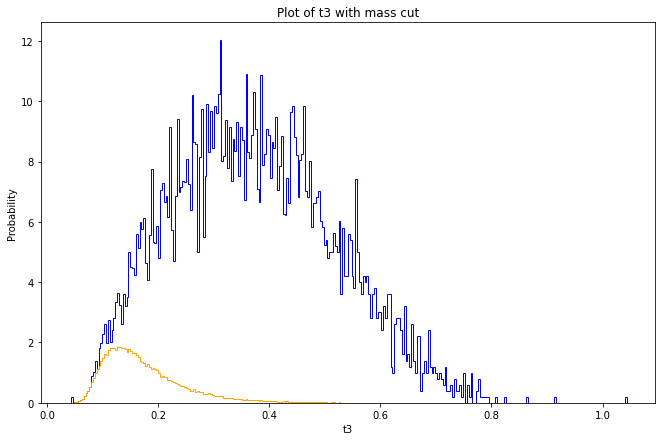

In [23]:
plot_mult('t3')

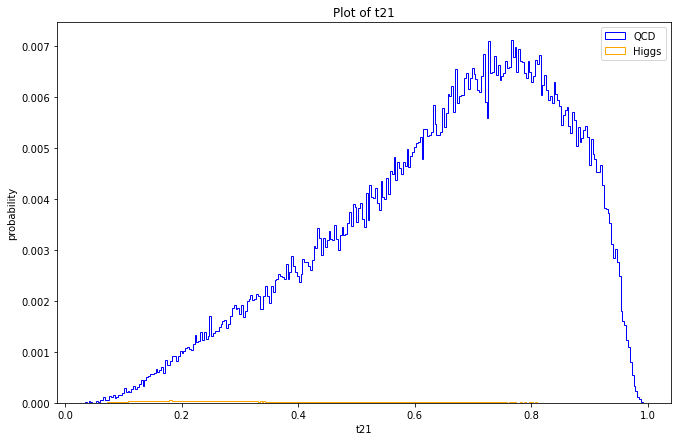

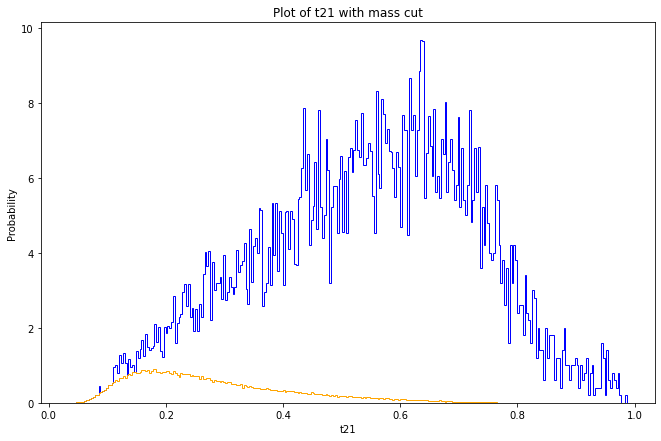

In [24]:
plot_mult('t21')

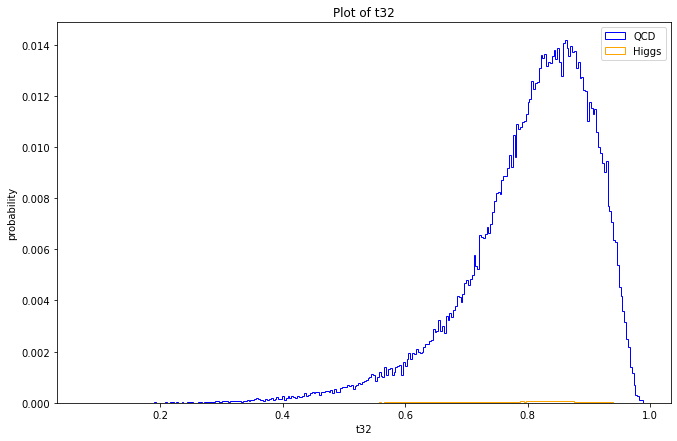

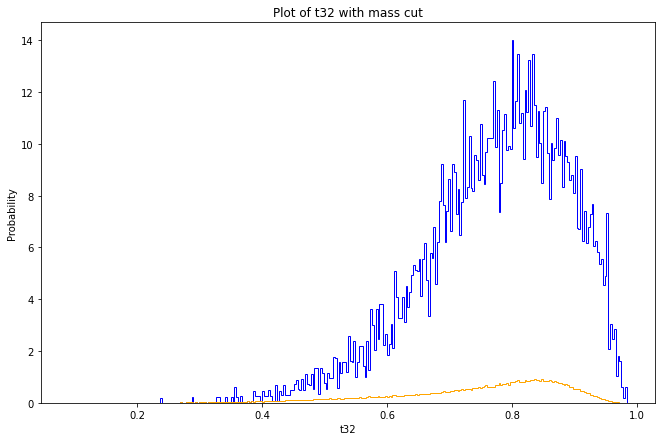

In [25]:
plot_mult('t32')

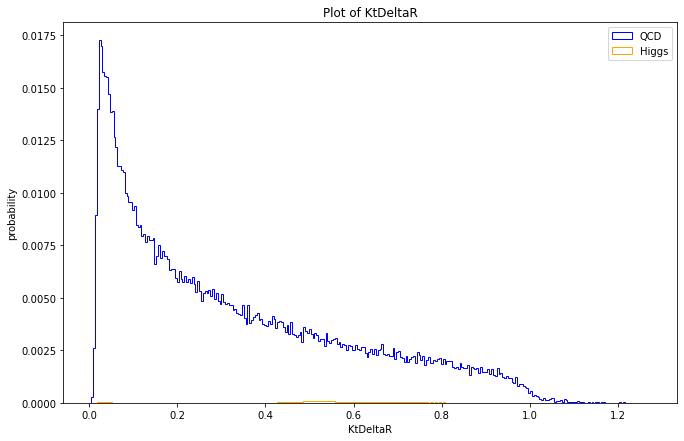

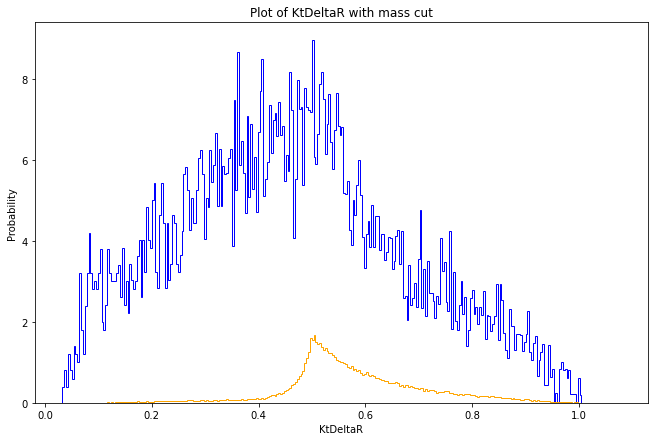

In [26]:
plot_mult('KtDeltaR')

-Can you identify another feature as discriminative as mass? (i.e. equal or better significance after feature cut)

Other variables that have discriminative features may be angularity, d2, t2, t3, t21, and KtDeltaR. These variables' histograms with the mass cuts appear to be promising with respect to finding a higher significance with the more slices. 

I will have to keep in mind where most of my signal appears, because I want to cut where the background is bad and not very sensitive, and in return keep the areas that will increase my sensitivity.  

### 4. Optimize event selections using multiple features (if necessary)
Find a set of feature cuts which achieve high expected significance.

Compare significance (before/after event selection) derived in your pT samples to your lab partner. Describe your findings.

In [27]:
def slice_on_var(low, high, var):
    output = slicer(low, high, var, signal_slice, bkgd_slice)

In [94]:
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background, True)

Significance of 2.387 for a cut from 120.0 to 130.0


Angularity slice:

In [29]:
slice_on_var(0, .01, 'angularity')
slice_on_var(0, .015, 'angularity')
slice_on_var(0, .001, 'angularity')

Significance of 2.544 for a cut from 0.0 to 0.0
Significance of 2.453 for a cut from 0.0 to 0.0
Significance of 1.054 for a cut from 0.0 to 0.0


d2 slice:

In [30]:
slice_on_var(0, 5, 'd2')
slice_on_var(0, 3, 'd2')
slice_on_var(0, 1, 'd2')
slice_on_var(0, 1.5, 'd2')
slice_on_var(0, 1.55, 'd2')

Significance of 2.404 for a cut from 0.0 to 5.0
Significance of 2.725 for a cut from 0.0 to 3.0
Significance of 8.210 for a cut from 0.0 to 1.0
Significance of 5.349 for a cut from 0.0 to 1.5
Significance of 5.110 for a cut from 0.0 to 1.6


t2 slice:

In [31]:
slice_on_var(0, .5, 't2')
slice_on_var(0, .3, 't2')
slice_on_var(0, .2, 't2')
slice_on_var(0, .75, 't2')
slice_on_var(0, 1, 't2')

Significance of 3.148 for a cut from 0.0 to 0.5
Significance of 4.465 for a cut from 0.0 to 0.3
Significance of 5.618 for a cut from 0.0 to 0.2
Significance of 2.496 for a cut from 0.0 to 0.8
Significance of 2.389 for a cut from 0.0 to 1.0


Both d2 and t2 appeared to have a sensitive range to the cuts, but I can get higher significance with a smaller cut on d2, so I will use that. 

## Lab 8

In [32]:
high_lum = pd.read_hdf('data_highLumi_pt_250_500.h5')
low_lum = pd.read_hdf('data_lowLumi_pt_250_500.h5')

print('high lum: ', high_lum.shape)
print('low lum: ', low_lum.shape)

high lum:  (40344, 14)
low lum:  (4060, 14)


### 1. High luminosity data
For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection.

Evaluate observed significance and compare your results to expectation.

In [33]:
def slice_lumi(lower, upper, key, lumi):
    
    ind_lumi_below = lumi[lumi[key] < lower].index
    ind_lumi_above = lumi[lumi[key] > upper].index
    new_lumi = lumi.drop(ind_lumi_below)
    new_lumi = new_lumi.drop(ind_lumi_above)
    
    return new_lumi

In [34]:
def plot_stack_norm_high(key):
    bg_wt = np.full(100000,(20000/21000)* (len(high_lum)/100000))
    sig_wt = np.full(100000, (100/21000) *(len(high_lum)/100000))
    lum_wt = np.full(len(high_lum), len(high_lum)/100000)
    plt.hist([signal[key], background[key], high_lum[key]], bins = 300, weights = [sig_wt,bg_wt,lum_wt], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD', 'High Lum'], color = ['orange', 'blue', 'green']) 
    plt.xlabel(key)
    plt.ylabel("probability")
    plt.title('Plot of ' + key)
    if key == 'd2':
        plt.xlim([0, 40])
    plt.legend()
    plt.show()

### High luminosity without event selection

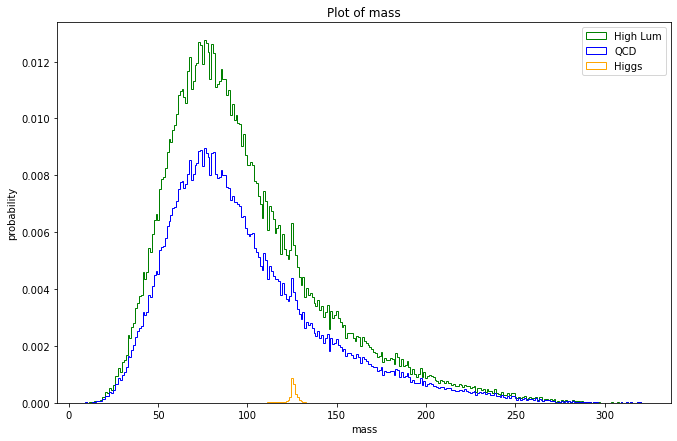

In [35]:
plot_stack_norm_high('mass')

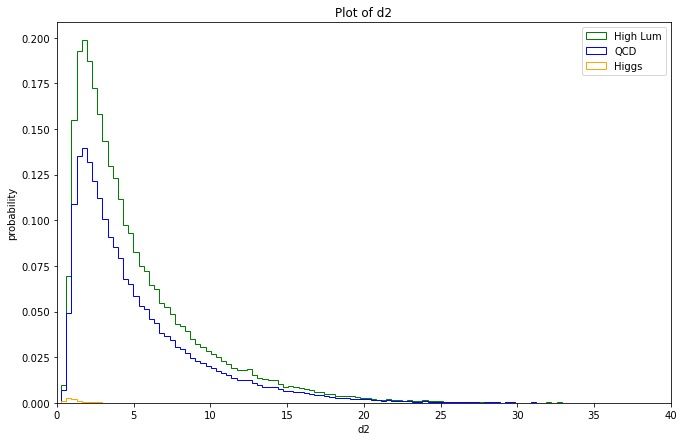

In [36]:
plot_stack_norm_high('d2')

In [95]:
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background, False)

In [38]:
def plot_stack_slice_high(key):
    if key == 'mass':
        lum_slice = slice_lumi(120, 130, 'mass', high_lum)
    else:
        lum_slice = slice_lumi(0, 1.5, 'd2', high_lum)
    sig_wt = np.full(len(signal_slice),(20000/21000)* (len(lum_slice)/100000))
    bg_wt = np.full(len(bkgd_slice), (100/21000) *(len(lum_slice)/100000))
    lum_wt = np.full(len(lum_slice), len(lum_slice)/100000)
    plt.hist([signal_slice[key], bkgd_slice[key]], bins = 300, weights = [sig_wt, bg_wt], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD'], color = ['orange', 'blue'])
    plt.hist(lum_slice[key], bins = 300, density= True, histtype = 'step', label = 'High Lum', color = 'green')
    plt.xlabel(key)
    plt.legend()
    plt.ylabel('Probability')
    plt.title('Plot of ' + key + ' with mass cut')
    plt.show()

### High Luminosity with event selection

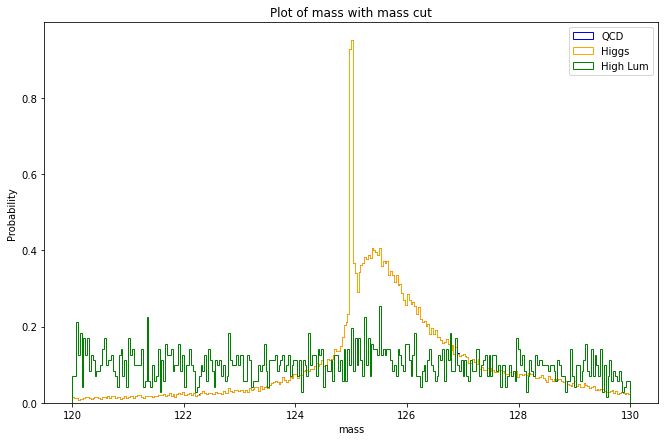

In [39]:
plot_stack_slice_high('mass')

In [96]:
signal_slice, bkgd_slice, sigma = slicer(0, 1.5, 'd2', signal, background, False)

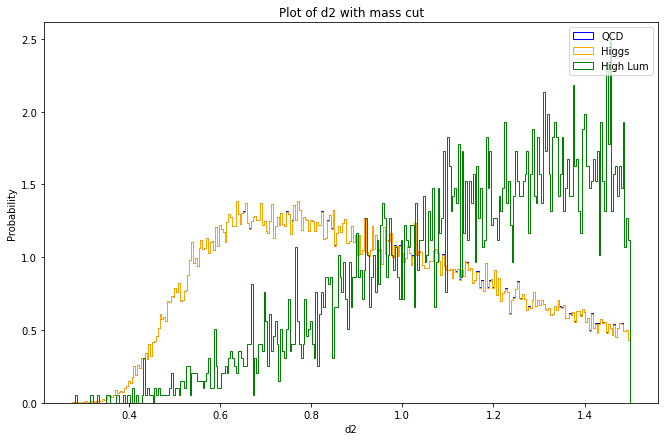

In [41]:
plot_stack_slice_high('d2')

In [104]:
qcd_sliced, higgs_sliced, sigma = slicer(120, 130 ,'mass', signal, background, False)
lumi_slice = slice_lumi(120, 130, 'mass', high_lum)
qcd_sliced, higgs_sliced, sigma = slicer(0, 1.5 ,'d2', higgs_sliced, qcd_sliced, False)
lumi_slice = slice_lumi(0, 1.5, 'd2', lumi_slice)

lam = int(len(qcd_sliced) * 0.2) 

highlum = len(lumi_slice)
prob = stats.poisson.sf(highlum, lam)
sigmahigh = stats.norm.isf(prob)
print(f'The significance of low luminosity with event selection is {sigmahigh:.4f} sigma.')

The significance of low luminosity with event selection is 16.5142 sigma.


### 2. Low luminosity data
Do as before with the high luminosity data and comment on the difference.

In [44]:
def plot_stack_norm_low(key):
    plt.hist([signal[key], background[key], low_lum[key]], bins = 300, weights = [[.001]*len(signal),[.2]*len(background), [.4]*len(low_lum)], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD', 'Low Lum'], color = ['orange', 'blue', 'green']) 
    plt.xlabel(key)
    plt.ylabel("probability")
    plt.title('Plot of ' + key)
    if key == 'd2':
        plt.xlim([0, 40])
    plt.legend()
    plt.show()

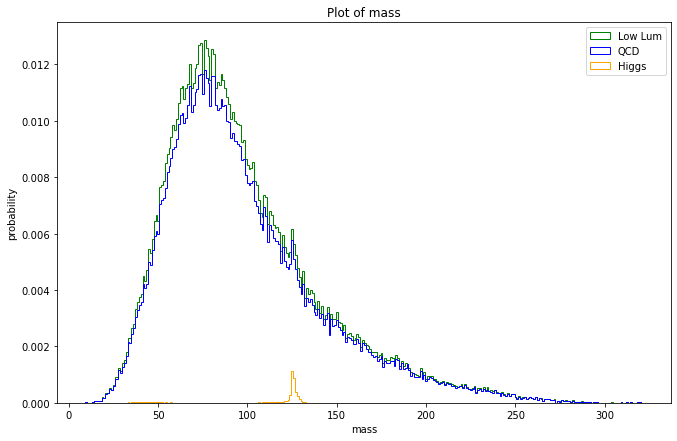

In [45]:
plot_stack_norm_low('mass')

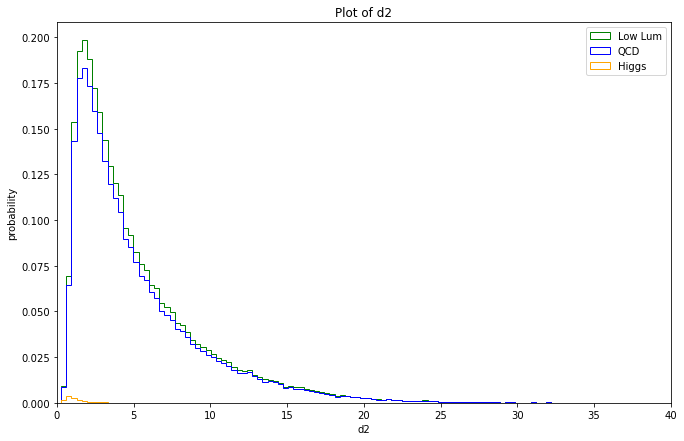

In [46]:
plot_stack_norm_low('d2')

In [47]:
def plot_stack_slice_low(key):
    if key == 'mass':
        lum_slice = slice_lumi(120, 130, 'mass', low_lum)
    else:
        lum_slice = slice_lumi(0, 1.5, 'd2', low_lum)
    sig_wt = np.full(len(signal_slice),(20000/21000)* (len(lum_slice)/100000))
    bg_wt = np.full(len(bkgd_slice), (100/21000) *(len(lum_slice)/100000))
    lum_wt = np.full(len(lum_slice), len(lum_slice)/100000)
    plt.hist([signal_slice[key], bkgd_slice[key]], bins = 300, weights = [sig_wt, bg_wt], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD'], color = ['orange', 'blue'])
    plt.hist(lum_slice[key], bins = 300, density= True, histtype = 'step', label = 'Low Lum', color = 'green')
    plt.xlabel(key)
    plt.legend()
    plt.ylabel('Probability')
    plt.title('Plot of ' + key + ' with mass cut')
    plt.show()

In [98]:
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background, False)

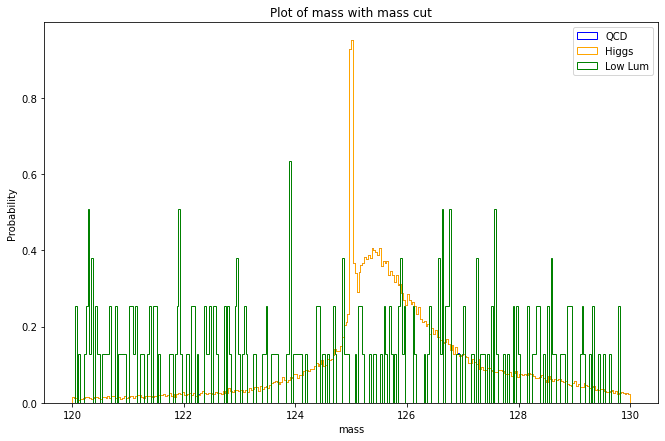

In [49]:
plot_stack_slice_low('mass')

In [99]:
signal_slice, bkgd_slice, sigma = slicer(0, 1.5, 'd2', signal, background, False)

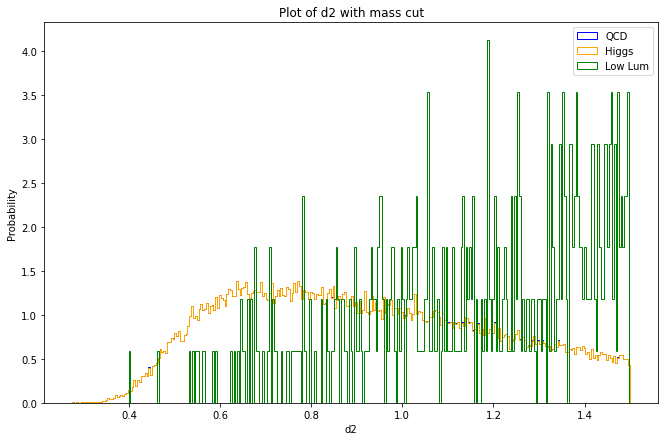

In [51]:
plot_stack_slice_low('d2')

In [105]:
qcd_sliced, higgs_sliced, sigma = slicer(120, 130 ,'mass', signal, background, False)
lumi_slice = slice_lumi(120, 130, 'mass', low_lum)
qcd_sliced, higgs_sliced, sigma = slicer(0, 1.5 ,'d2', higgs_sliced, qcd_sliced, False)
lumi_slice = slice_lumi(0, 1.5, 'd2', lumi_slice)

lam = int(len(qcd_sliced) * 0.2) 

lowlumi = len(lumi_slice)
prob = stats.poisson.sf(lowlumi, lam)
sigma_low = stats.norm.isf(prob)
print(f'The significance of low luminosity events after event selection is {sigma_low:.4f} sigma.')

The significance of low luminosity events after event selection is -inf sigma.


### 3. 95% Confidence Level of signal yields

In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level upper limit of signal yield.

Evaluate the expected 95% confidence level upper limit

Evaluate the observed 95% confidence level upper limit

In [73]:
exp_higgs = int(len(signal_slice) * 0.001)
exp_data = exp_higgs + lam

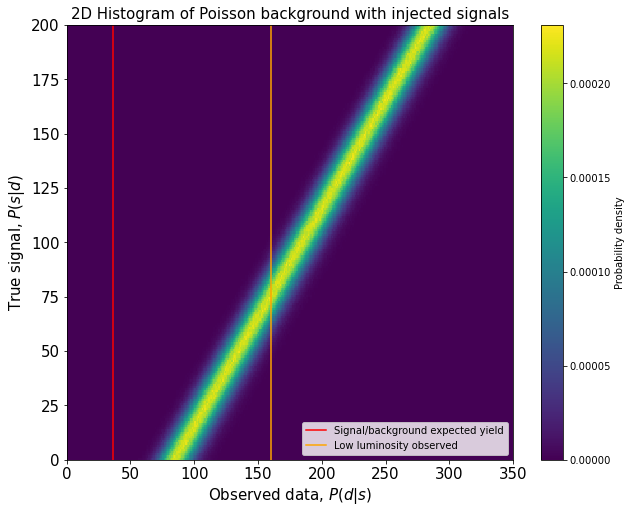

In [79]:
n = 10000000
plt.rcParams["figure.figsize"] = (10,8)
bg_exp = stats.poisson.rvs(lam, size = n)

signals = np.random.randint(0, 200, n)

datanew = bg_exp + signals

dataedges = np.linspace(0,350,351)
signaledges = np.linspace(0,200,201)

Psd, temp, temp2 = np.histogram2d(datanew, signals, bins=(dataedges, signaledges), density=True)
datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(datacenters, signalcenters, Psd.T, shading = 'auto')
plt.colorbar(label = 'Probability density')

# plot vertical line
y_obs = np.linspace(0,200,201)
x_exp = []
x_obs = []
for i in range (0, 201):
    x_exp.append(exp_data)
    x_obs.append(signal_lowLumi)
plt.plot(x_obs, y_obs, color = 'r', label = 'Signal/background expected yield')
plt.plot(x_exp, y_obs, color = 'orange', label = 'Low luminosity observed')

plt.title(f'2D Histogram of Poisson background with injected signals', fontsize=15)
plt.ylabel('True signal, $P(s|d)$', fontsize = 15)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 15)
plt.tick_params(labelsize=15)
plt.legend(loc = 'lower right')
plt.show()


In [81]:
limit = 0.95
prob = 0
signal = 0

for i in range (0,350):
    prob_signal = Psd[:,signal]
    prob_signal = prob_signal*(1/(np.sum(prob_signal)))

    for j in range (145, len(prob_signal)):
        prob += prob_signal[j]   
    if prob >= limit:
        break
    
    prob = 0       
    signal += 1
    
print(f'The expected {limit*100}% upper limit is {signal}.')


The expected 95.0% upper limit is 75.


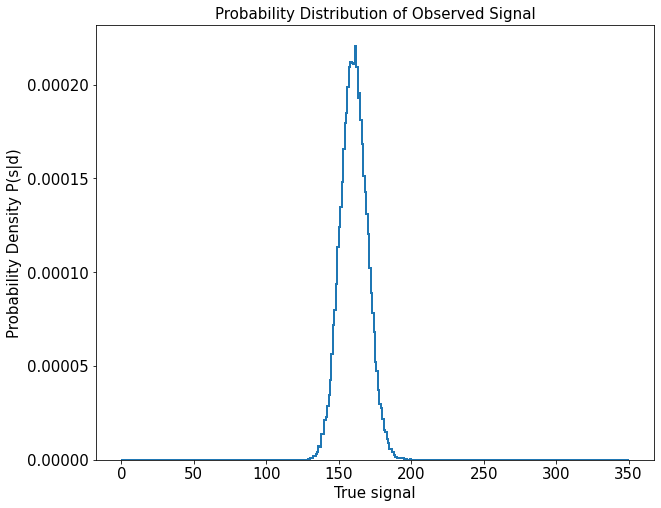

In [72]:
plt.stairs(Psd[:, signal], edges = dataedges, linewidth = 2)
plt.title(f'Probability Distribution of Observed Signal', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Probability Density P(s|d)', fontsize = 15)
plt.xlabel('True signal', fontsize = 15)
plt.show()

The upper 95% limit of an observed signal being true, is 75. This means that a signal of 75 would mean there's a 95% chance of observing 145 events or more. Which in turn means that if the Higgs signal were stronger than 75, this is where we would see a Higgs signal 95% of the time. 

In [89]:
limit = 0.95
prob = 0
signal = 0

for i in range (0,350):
    prob_signal = Psd[:,signal]
    prob_signal = prob_signal*(1/(np.sum(prob_signal)))

    for j in range (24, len(prob_signal)):
        prob += prob_signal[j]
    if prob >= limit:
        break
    
    prob = 0      
    signal += 1
    
print(f'The observed {limit*100}%  upper limit is {signal}.')


The observed 95.0%  upper limit is 0.


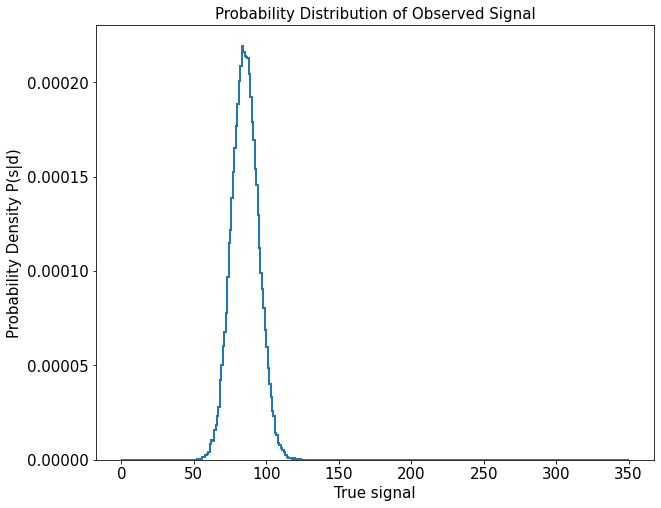

In [58]:
plt.stairs(Psd[:, signal], edges = dataedges, linewidth = 2)
plt.title(f'Probability Distribution of Observed Signal', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Probability Density P(s|d)', fontsize = 15)
plt.xlabel('True signal', fontsize = 15)
plt.show()

The upper limit being zero makes sense because a true signal above 0 would give us a higgs signal more than 95% of the time. This must mean that there are no higgs signals within the low luminosity data. 